In [1]:
import os
from collections import defaultdict
import json
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
import random
import ipywidgets as widgets
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms as T
from pathlib import Path
from IPython.display import display
import torch



___

# Import and Treat Data

In [3]:
# --- Rutas ---
# Original Dataset:
# https://public.roboflow.com/object-detection/self-driving-car/2/download/coco
export_dir = "/Users/josealmendarez/Downloads/Self Driving Car.v2-fixed-large.coco/export"
imgs_dir = os.path.join(export_dir, "imgs")
ann_file = os.path.join(export_dir, "_annotations.coco.json")

# Carpeta donde guardar el dataset limpio
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)
imgs_clean_dir = os.path.join(output_dir, "imgs")
os.makedirs(imgs_clean_dir, exist_ok=True)
metadata_dir = os.path.join(output_dir, "metadata")
os.makedirs(metadata_dir, exist_ok=True)
output_json = os.path.join(metadata_dir, "_annotations_clean.coco.json")

# --- Cargar COCO ---
with open(ann_file, "r") as f:
    coco = json.load(f)

# --- Filtrar duplicadas ---
prefix_map = defaultdict(list)
for img in coco["images"]:
    prefix = img["file_name"].split("_jpg.rf.")[0]
    prefix_map[prefix].append(img)

images_to_keep = []
image_ids_to_keep = set()

for imgs in prefix_map.values():
    keep = imgs[0]  # conservar la primera
    images_to_keep.append(keep)
    image_ids_to_keep.add(keep["id"])

annotations_clean = [
    ann for ann in coco["annotations"] if ann["image_id"] in image_ids_to_keep
]

# --- Guardar JSON limpio ---
coco_clean = {
    "images": images_to_keep,
    "annotations": annotations_clean,
    "categories": coco["categories"]
}

with open(output_json, "w") as f:
    json.dump(coco_clean, f)

# --- Copiar imágenes únicas ---
for img in images_to_keep:
    src_path = os.path.join(imgs_dir, img["file_name"])
    dst_path = os.path.join(imgs_clean_dir, img["file_name"])
    shutil.copy2(src_path, dst_path)

print(f"JSON limpio guardado en: {output_json}")
print(f"Imágenes únicas copiadas a: {imgs_clean_dir}")
print("Número total de imágenes únicas:", len(images_to_keep))

JSON limpio guardado en: dataset/metadata/_annotations_clean.coco.json
Imágenes únicas copiadas a: dataset/imgs
Número total de imágenes únicas: 15000


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


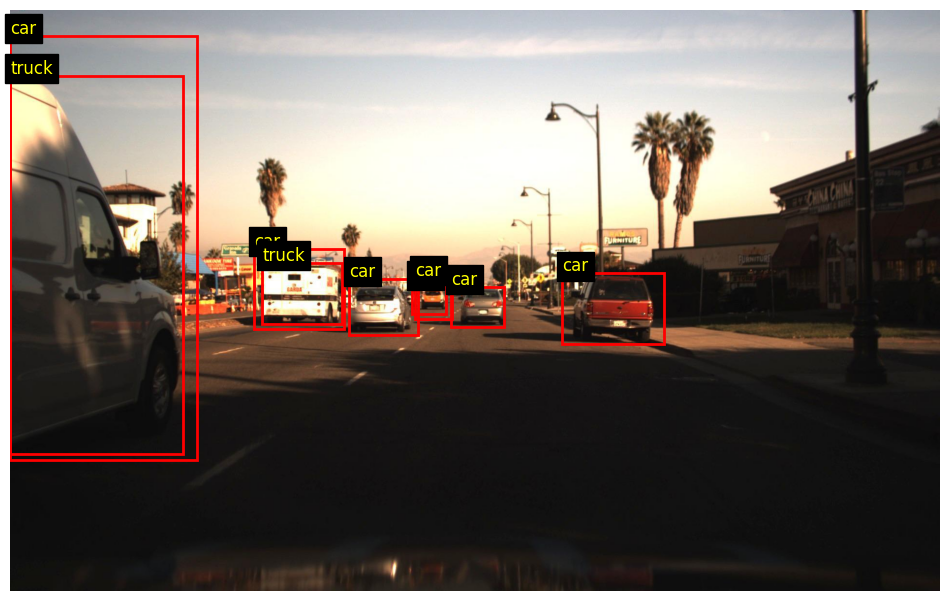

In [4]:
# --- Rutas del dataset limpio ---
clean_dir = "dataset"
imgs_clean_dir = os.path.join(clean_dir, "imgs")
ann_file_clean = os.path.join(clean_dir, "metadata", "_annotations_clean.coco.json")

# --- Cargar COCO limpio ---
coco_clean = COCO(ann_file_clean)

img_ids = coco_clean.getImgIds()

def mostrar_imagen_con_anotaciones_limpias(img_id):
    img_info = coco_clean.loadImgs(img_id)[0]
    img_path = os.path.join(imgs_clean_dir, img_info['file_name'])

    I = plt.imread(img_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(I)

    # Obtener anotaciones
    ann_ids = coco_clean.getAnnIds(imgIds=img_id)
    anns = coco_clean.loadAnns(ann_ids)

    for ann in anns:
        x, y, w, h = ann['bbox']
        cat_name = coco_clean.loadCats(ann['category_id'])[0]['name']
        # Dibujar el bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Escribir la categoría
        ax.text(x, y-5, cat_name, color='yellow', fontsize=12, backgroundcolor='black')

    plt.axis('off')
    plt.show()

# Ejemplo: mostrar la primera imagen del dataset limpio
mostrar_imagen_con_anotaciones_limpias(img_ids[5])

___

# Divide Data into Train and Test

In [5]:
# --- Rutas ---
clean_dir = "dataset"
imgs_dir = os.path.join(clean_dir, "imgs")
ann_file_clean = os.path.join(clean_dir, "metadata", "_annotations_clean.coco.json")

# Carpeta donde guardar train/test
split_dir = os.path.join(clean_dir, "splits")
os.makedirs(split_dir, exist_ok=True)

# --- Cargar dataset limpio ---
with open(ann_file_clean, "r") as f:
    coco = json.load(f)

# --- Seleccionar 500 imágenes aleatorias ---
n = 100
all_images = coco["images"]
if len(all_images) > n:
    all_images = random.sample(all_images, n)

image_ids = set(img["id"] for img in all_images)

# --- Dividir en train/test 80/20 ---
num_train = int(0.8 * len(all_images))
train_images = all_images[:num_train]
test_images = all_images[num_train:]

train_ids = set(img["id"] for img in train_images)
test_ids = set(img["id"] for img in test_images)

# --- Filtrar anotaciones ---
train_annotations = [ann for ann in coco["annotations"] if ann["image_id"] in train_ids]
test_annotations = [ann for ann in coco["annotations"] if ann["image_id"] in test_ids]

# --- Crear JSONs ---
train_coco = {
    "images": train_images,
    "annotations": train_annotations,
    "categories": coco["categories"]
}

test_coco = {
    "images": test_images,
    "annotations": test_annotations,
    "categories": coco["categories"]
}

# --- Guardar ---
train_file = os.path.join(split_dir, "_annotations_train.json")
test_file = os.path.join(split_dir, "_annotations_test.json")

with open(train_file, "w") as f:
    json.dump(train_coco, f)
with open(test_file, "w") as f:
    json.dump(test_coco, f)

print(f"Train JSON: {train_file} ({len(train_images)} imágenes)")
print(f"Test JSON: {test_file} ({len(test_images)} imágenes)")

Train JSON: dataset/splits/_annotations_train.json (80 imágenes)
Test JSON: dataset/splits/_annotations_test.json (20 imágenes)


___

# Build Model

In [2]:
# --- Configuración de rutas ---
dataset_dir = "dataset"
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

# --- Dataset COCO ---
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, ann_file, transforms=None):
        from pycocotools.coco import COCO
        import PIL.Image as Image
        self.Image = Image
        self.coco = COCO(ann_file)
        self.root = imgs_dir
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img = self.Image.open(os.path.join(self.root, path)).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Convertir formato COCO [x, y, w, h] a formato PyTorch [x1, y1, x2, y2]
        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            # Asegurar que las cajas sean válidas
            if w > 0 and h > 0:
                boxes.append([x, y, x + w, y + h])
                labels.append(ann['category_id'])
                areas.append(ann.get('area', w * h))
                iscrowd.append(ann.get('iscrowd', 0))

        # Manejar imágenes sin anotaciones
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            areas = torch.tensor(areas, dtype=torch.float32)
            iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'area': areas,
            'iscrowd': iscrowd,
            'image_id': torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

# --- Transforms ---
transforms = T.Compose([T.ToTensor()])

# --- Cargar datasets usando splits existentes ---
train_dataset = CocoDataset(
    imgs_dir=f"{dataset_dir}/imgs",
    ann_file=f"{dataset_dir}/splits/_annotations_train.json",
    transforms=transforms
)
test_dataset = CocoDataset(
    imgs_dir=f"{dataset_dir}/imgs",
    ann_file=f"{dataset_dir}/splits/_annotations_test.json",
    transforms=transforms
)

# --- Función para crear modelo ---
def get_model(num_classes=13, weight_init="default", dropout_rate=0.5):
    backbone = resnet_fpn_backbone('resnet18', weights='IMAGENET1K_V1')
    model = FasterRCNN(backbone, num_classes=num_classes)

    # Aplicar inicialización de pesos
    if weight_init == "xavier":
        for m in model.roi_heads.box_predictor.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    elif weight_init == "kaiming":
        for m in model.roi_heads.box_predictor.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # Aplicar dropout en el box predictor (donde tiene más sentido)
    if dropout_rate > 0:
        # Modificar el cls_score layer para incluir dropout
        original_cls_score = model.roi_heads.box_predictor.cls_score
        model.roi_heads.box_predictor.cls_score = nn.Sequential(
            nn.Dropout(dropout_rate),
            original_cls_score
        )

        # Modificar el bbox_pred layer para incluir dropout
        original_bbox_pred = model.roi_heads.box_predictor.bbox_pred
        model.roi_heads.box_predictor.bbox_pred = nn.Sequential(
            nn.Dropout(dropout_rate),
            original_bbox_pred
        )

    return model

# --- Función de entrenamiento ---
def train_model(optimizer_name="SGD", lr=0.005, weight_decay=0.0, batch_size=4,
                epochs=2, weight_init="default", dropout=False, dropout_rate=0.5):
    device = torch.device("cpu")
    print(f"Usando dispositivo: {device}")

    # Crear modelo
    model = get_model(
        weight_init=weight_init,
        dropout_rate=dropout_rate if dropout else 0.0
    ).to(device)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=0  # Evitar problemas con multiprocessing en Jupyter
    )

    # Optimizer con learning rates ajustados según el optimizador
    if optimizer_name == "SGD":
        optimizer = optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=0.9,
            weight_decay=weight_decay
        )
    elif optimizer_name == "Adam":
        # Adam típicamente requiere un learning rate más bajo
        adjusted_lr = lr if lr < 0.001 else lr / 5
        optimizer = optim.Adam(
            model.parameters(),
            lr=adjusted_lr,
            weight_decay=weight_decay
        )
        print(f"Usando Adam con lr ajustado: {adjusted_lr}")
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

    losses_all = []
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0

        for batch_idx, (imgs, targets) in enumerate(train_loader):
            # Filtrar imágenes sin anotaciones válidas
            valid_samples = []
            for img, target in zip(imgs, targets):
                if len(target['boxes']) > 0:
                    valid_samples.append((img, target))

            if len(valid_samples) == 0:
                print(f"Epoch {epoch+1} Batch {batch_idx+1}: Sin anotaciones válidas, saltando...")
                continue

            imgs, targets = zip(*valid_samples)

            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            try:
                loss_dict = model(imgs, targets)
                losses = sum(loss for loss in loss_dict.values())

                optimizer.zero_grad()
                losses.backward()

                # Gradient clipping para evitar explosión de gradientes
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                epoch_loss += losses.item()
                batch_count += 1

                if batch_idx % 5 == 0:  # Mostrar cada 5 batches
                    print(f"Epoch {epoch+1} Batch {batch_idx+1}/{len(train_loader)} - Loss: {losses.item():.4f}")

            except Exception as e:
                print(f"Error en batch {batch_idx+1}: {str(e)}")
                continue

        if batch_count > 0:
            avg_loss = epoch_loss / batch_count
            losses_all.append(avg_loss)
            print(f"✓ Epoch {epoch+1} completado. Avg Loss: {avg_loss:.4f}")
        else:
            print(f"✗ Epoch {epoch+1}: No se procesaron batches válidos")

    # Guardar modelo y metadata
    exp_idx = len(list(results_dir.glob('exp_*'))) + 1
    exp_path = results_dir / f"exp_{exp_idx}"
    exp_path.mkdir(exist_ok=True)

    torch.save(model, exp_path / "model.pth")
    metadata = {
        "optimizer": optimizer_name,
        "lr": lr,
        "weight_decay": weight_decay,
        "batch_size": batch_size,
        "epochs": epochs,
        "weight_init": weight_init,
        "dropout": dropout,
        "dropout_rate": dropout_rate if dropout else 0.0,
        "losses": losses_all,
        "device": str(device),
        "num_classes": 13
    }
    with open(exp_path / "metadata.json", "w") as f:
        json.dump(metadata, f, indent=4)

    print(f"\n✓ Experimento guardado en {exp_path}")
    return exp_path

# --- Widgets ---
optimizer_widget = widgets.Dropdown(
    options=["SGD", "Adam", "RMSprop"],
    value="SGD",
    description="Optimizer"
)
lr_widget = widgets.FloatSlider(
    value=0.005,
    min=0.0001,
    max=0.01,
    step=0.0005,
    description="Learning rate"
)
weight_decay_widget = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=0.1,
    step=0.005,
    description="Weight decay"
)
batch_size_widget = widgets.IntSlider(
    value=4,
    min=1,
    max=16,
    step=1,
    description="Batch size"
)
epochs_widget = widgets.IntSlider(
    value=2,
    min=1,
    max=50,
    step=1,
    description="Epochs"
)
weight_init_widget = widgets.Dropdown(
    options=["default", "xavier", "kaiming"],
    value="default",
    description="Weight init"
)
dropout_widget = widgets.Checkbox(
    value=False,
    description="Dropout"
)
dropout_rate_widget = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=0.9,
    step=0.1,
    description="Dropout rate"
)

train_button = widgets.Button(description="Entrenar", button_style="success")
output_widget = widgets.Output()

def on_train_clicked(b):
    with output_widget:
        output_widget.clear_output()
        try:
            exp_path = train_model(
                optimizer_name=optimizer_widget.value,
                lr=lr_widget.value,
                weight_decay=weight_decay_widget.value,
                batch_size=batch_size_widget.value,
                epochs=epochs_widget.value,
                weight_init=weight_init_widget.value,
                dropout=dropout_widget.value,
                dropout_rate=dropout_rate_widget.value
            )
            print(f"\n🎉 Entrenamiento completado exitosamente!")
        except Exception as e:
            print(f"\n❌ Error durante el entrenamiento: {str(e)}")
            import traceback
            traceback.print_exc()

train_button.on_click(on_train_clicked)

ui = widgets.VBox([
    optimizer_widget,
    lr_widget,
    weight_decay_widget,
    batch_size_widget,
    epochs_widget,
    weight_init_widget,
    dropout_widget,
    dropout_rate_widget,
    train_button,
    output_widget
])

display(ui)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


___
# Evaluate Model

✅ IoU promedio en test: 0.2325


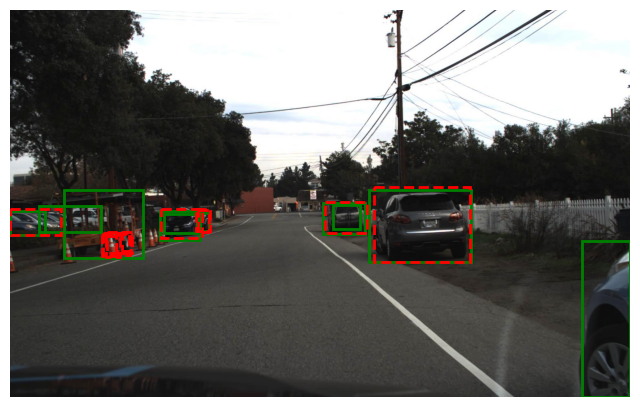

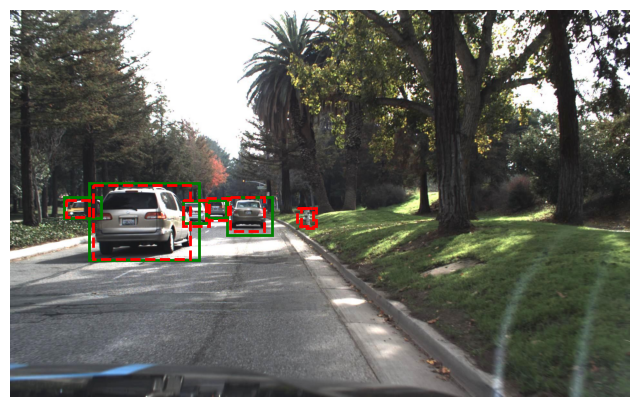

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision.ops import box_iou
import matplotlib.pyplot as plt

# 1️⃣ Cargar modelo completo
model_path = "results/exp_4/model.pth"  # ajusta si tu experimento tiene otro número
model = torch.load(model_path, weights_only=False)
device = torch.device("cpu")  # o "cuda" si tienes GPU
model.to(device)
model.eval()

# 2️⃣ Preparar DataLoader para test
test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3️⃣ Evaluación simple: IoU promedio
all_ious = []

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(imgs)

        for out, tgt in zip(outputs, targets):
            if len(tgt['boxes']) > 0 and len(out['boxes']) > 0:
                iou = box_iou(out['boxes'], tgt['boxes']).diag().mean().item()
                all_ious.append(iou)

avg_iou = sum(all_ious) / len(all_ious)
print(f"✅ IoU promedio en test: {avg_iou:.4f}")

# 4️⃣ Opcional: visualizar algunas predicciones
def visualize_predictions(img_tensor, target_boxes, pred_boxes):
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt
    import numpy as np
    from torchvision.transforms import functional as F

    # Convertir a imagen normal
    img = F.to_pil_image(img_tensor.cpu().clamp(0, 1))
    img = np.array(img)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()

    # Cajas reales (verde)
    for box in target_boxes:
        x1, y1, x2, y2 = box.cpu().numpy()
        ax.add_patch(patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            edgecolor='green', facecolor='none', linewidth=2
        ))

    # Cajas predichas (rojo)
    for box in pred_boxes:
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        ax.add_patch(patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            edgecolor='red', facecolor='none', linewidth=2, linestyle='--'
        ))

    plt.axis('off')
    plt.show()

# Visualizar 2 imágenes de test
imgs, targets = next(iter(test_loader))
outputs = model([img.to(device) for img in imgs])
for i in range(2):
    visualize_predictions(imgs[i], targets[i]['boxes'], outputs[i]['boxes'])